## LGBM CV Tuning and Seed Diversification
_By Nick Brooks, June 2018_

Inspiration for this kernel is from [@Silogram](https://www.kaggle.com/psilogram)'s [Post](https://www.kaggle.com/c/home-credit-default-risk/discussion/58332).

In [20]:
import time
notebookstart= time.time()

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import gc
import random
random.seed(2018)

# Models Packages
from sklearn import metrics
from sklearn.metrics import mean_squared_error
from sklearn import feature_selection
from sklearn.model_selection import train_test_split
from IPython.display import display

# Gradient Boosting
import lightgbm as lgb

# Visualization
import seaborn as sns
import matplotlib.pyplot as plt
get_ipython().magic('matplotlib inline')

# Specify index/ target name
id_col = "ID"
target_var = "target"

# House Keeping Parameters
Debug = False
Home = False
Build_Results_csv = False # if running for first time

results = pd.DataFrame(columns = ["Rounds","Score","STDV", "LB", "Parameters"])
if Build_Results_csv is True & Home is True: results.to_csv("results.csv")
if Home is True:
    import os
    path = r"D:\My Computer\DATA\Santander"
    os.chdir(path)
    
    print("Data Load Stage")
    training = pd.read_csv('train.csv', index_col = id_col)
    if Debug is True : training = training.sample(100)
    traindex = training.index
    testing = pd.read_csv('test.csv', index_col = id_col)
    if Debug is True : testing = testing.sample(100)
    testdex = testing.index
else:
    print("Data Load Stage")
    training = pd.read_csv('../input/train.csv', index_col = id_col)
    if Debug is True : training = training.sample(100)
    traindex = training.index
    testing = pd.read_csv('../input/test.csv', index_col = id_col)
    if Debug is True : testing = testing.sample(100)
    testdex = testing.index

y = np.log1p(training[target_var])
training.drop(target_var,axis=1, inplace=True)
print('Train shape: {} Rows, {} Columns'.format(*training.shape))
print('Test shape: {} Rows, {} Columns'.format(*testing.shape))

print("Combine Train and Test")
df = pd.concat([training,testing],axis=0)
del training, testing
gc.collect()
print('\nAll Data shape: {} Rows, {} Columns'.format(*df.shape))

Data Load Stage
Train shape: 4459 Rows, 4991 Columns
Test shape: 49343 Rows, 4991 Columns
Combine Train and Test

All Data shape: 53802 Rows, 4991 Columns


In [21]:
# Modeling Datasets
test_df = df.loc[testdex,:]
vocab = df.columns

# LGBM Dataset
lgtrain = lgb.Dataset(df.loc[traindex,vocab],y ,feature_name = "auto")
print("Starting LightGBM. Train shape: {}, Test shape: {}".format(df.loc[testdex,:].shape,test_df.shape))
print("Feature Num: ",len(vocab))
# del df; 
# gc.collect();

Starting LightGBM. Train shape: (49343, 4991), Test shape: (49343, 4991)
Feature Num:  4991


## Modeling Stage

In [22]:
print("Light Gradient Boosting Regressor: ")
# t=np.log1p(target)

X_train, X_val, y_train, y_val = train_test_split(df, y, test_size=0.2, random_state=0)

train_data=lightgbm.Dataset(X_train,y_train)
valid_data=lightgbm.Dataset(X_val,y_val)
lgbm_params =  {
    'task': 'train',
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': 'rmse',
    "learning_rate": 0.01,
    "num_leaves": 180,
    "feature_fraction": 0.50,
    "bagging_fraction": 0.50,
    'bagging_freq': 4,
    "max_depth": -1,
    "reg_alpha": 0.3,
    "reg_lambda": 0.1,
    #"min_split_gain":0.2,
    "min_child_weight":10,
    'zero_as_missing':True
                }
lgbm = lightgbm.train(lgbm_params,
                 train_data,
                 25000,
                 valid_sets=valid_data,
                 early_stopping_rounds= 80,
                 verbose_eval= False
                 )

Light Gradient Boosting Regressor: 


ValueError: Found input variables with inconsistent numbers of samples: [53802, 4459]

## Cross-Validation
**Hand Tuning:**

In [4]:
modelstart= time.time()
# Find Optimal Parameters / Boosting Rounds
lgb_cv = lgb.cv(
    params = lgbm_params,
    train_set = lgtrain,
    num_boost_round=2000,
    stratified=False,
    nfold = 5,
    verbose_eval=50,
    seed = 23,
    early_stopping_rounds=75)

optimal_rounds = np.argmin(lgb_cv['rmse-mean'])
best_cv_score = min(lgb_cv['rmse-mean'])

print("\nOptimal Round: {}\nOptimal Score: {} + {}".format(
    optimal_rounds,best_cv_score,lgb_cv['rmse-stdv'][optimal_rounds]))

results = results.append({"Rounds": optimal_rounds,
                          "Score": best_cv_score,
                          "STDV": lgb_cv['rmse-stdv'][optimal_rounds],
                          "LB": None,
                          "Parameters": lgbm_params}, ignore_index=True)
if Home is True:
    with open('results.csv', 'a') as f:
        results.to_csv(f, header=False)

[50]	cv_agg's rmse: 1.58742 + 0.0305161
[100]	cv_agg's rmse: 1.50458 + 0.0316924
[150]	cv_agg's rmse: 1.46337 + 0.0325538
[200]	cv_agg's rmse: 1.44265 + 0.0327991
[250]	cv_agg's rmse: 1.43354 + 0.032863
[300]	cv_agg's rmse: 1.43088 + 0.0337591
[350]	cv_agg's rmse: 1.42942 + 0.0337614
[400]	cv_agg's rmse: 1.43018 + 0.0342158

Optimal Round: 339
Optimal Score: 1.4292676122745214 + 0.03369025245241399


In [5]:
pd.set_option('max_colwidth', 800)
display(results.sort_values(by="Score",ascending = True))

,Rounds,Score,STDV,LB,Parameters
0,339,1.429268,0.03369,None,"{'task': 'train', 'boosting_type': 'gbdt', 'objective': 'regression', 'metric': 'rmse', 'learning_rate': 0.01, 'num_leaves': 180, 'feature_fraction': 0.5, 'bagging_fraction': 0.5, 'bagging_freq': 4, 'max_depth': -1, 'reg_alpha': 0.3, 'reg_lambda': 0.1, 'min_child_weight': 10, 'zero_as_missing': True, 'verbose': 1}"


**Iterative Tuning:** <br>
My current learning rate is 0.005. Say I what to see how well it's neigbors perform..

In [6]:
learning_rates = [0.012,0.008]
for param in learning_rates:
    print("Learning Rate: ", param)
    modelstart= time.time()
    lgbm_params["learning_rate"] = param
    # Find Optimal Parameters / Boosting Rounds
    lgb_cv = lgb.cv(
        params = lgbm_params,
        train_set = lgtrain,
        num_boost_round=10000,
        stratified=False,
        nfold = 5,
        verbose_eval=200,
        seed = 23,
        early_stopping_rounds=75)

    optimal_rounds = np.argmin(lgb_cv['rmse-mean'])
    best_cv_score = min(lgb_cv['rmse-mean'])

    print("Optimal Round: {}\nOptimal Score: {} + {}".format(
        optimal_rounds,best_cv_score,lgb_cv['rmse-stdv'][optimal_rounds]))
    print("###########################################################################################")

    results = results.append({"Rounds": optimal_rounds,
                              "Score": best_cv_score,
                              "STDV": lgb_cv['rmse-stdv'][optimal_rounds],
                              "LB": None,
                              "Parameters": lgbm_params}, ignore_index=True)
    if Home is True:
        with open('results.csv', 'a') as f:
            results.to_csv(f, header=False)
        # results = pd.read_csv("results.csv")

Learning Rate:  0.012
[200]	cv_agg's rmse: 1.4344 + 0.0334958
Optimal Round: 284
Optimal Score: 1.4287010145278027 + 0.034950291968031635
###########################################################################################
Learning Rate:  0.008
[200]	cv_agg's rmse: 1.45785 + 0.0314299
[400]	cv_agg's rmse: 1.42848 + 0.0341142
Optimal Round: 445
Optimal Score: 1.4269354837748918 + 0.0343219787670181
###########################################################################################


In [7]:
pd.set_option('max_colwidth', 800)
display(results.sort_values(by="Score",ascending = True))

,Rounds,Score,STDV,LB,Parameters
2,445,1.426935,0.034322,None,"{'task': 'train', 'boosting_type': 'gbdt', 'objective': 'regression', 'metric': 'rmse', 'learning_rate': 0.008, 'num_leaves': 180, 'feature_fraction': 0.5, 'bagging_fraction': 0.5, 'bagging_freq': 4, 'max_depth': -1, 'reg_alpha': 0.3, 'reg_lambda': 0.1, 'min_child_weight': 10, 'zero_as_missing': True, 'verbose': 1}"
1,284,1.428701,0.034950,None,"{'task': 'train', 'boosting_type': 'gbdt', 'objective': 'regression', 'metric': 'rmse', 'learning_rate': 0.008, 'num_leaves': 180, 'feature_fraction': 0.5, 'bagging_fraction': 0.5, 'bagging_freq': 4, 'max_depth': -1, 'reg_alpha': 0.3, 'reg_lambda': 0.1, 'min_child_weight': 10, 'zero_as_missing': True, 'verbose': 1}"
0,339,1.429268,0.033690,None,"{'task': 'train', 'boosting_type': 'gbdt', 'objective': 'regression', 'metric': 'rmse', 'learning_rate': 0.008, 'num_leaves': 180, 'feature_fraction': 0.5, 'bagging_fraction': 0.5, 'bagging_freq': 4, 'max_depth': -1, 'reg_alpha': 0.3, 'reg_lambda': 0.1, 'min_child_weight': 10, 'zero_as_missing': True, 'verbose': 1}"


## Final Model and Seed Diversification
Out-of-Fold Methods are very poplular in public kernels at the moment. This is a alternative that operates in a similar way. Instead of explicitly dividing the data, the randomized seed changes the row and column subsampling choice which also forces the model to do without some data to achieve a more diverse, robust prediction.

In [8]:
# Best Parameters
final_model_params = results.iloc[results["Score"].idxmin(),:]["Parameters"]
optimal_rounds = results.iloc[results["Score"].idxmin(),:]["Rounds"]
print("Parameters for Final Models:\n",final_model_params)
print("Score: {} +/- {}".format(results.iloc[results["Score"].idxmin(),:]["Score"],results.iloc[results["Score"].idxmin(),:]["STDV"]))
print("Rounds: ", optimal_rounds)

Parameters for Final Models:
 {'task': 'train', 'boosting_type': 'gbdt', 'objective': 'regression', 'metric': 'rmse', 'learning_rate': 0.008, 'num_leaves': 180, 'feature_fraction': 0.5, 'bagging_fraction': 0.5, 'bagging_freq': 4, 'max_depth': -1, 'reg_alpha': 0.3, 'reg_lambda': 0.1, 'min_child_weight': 10, 'zero_as_missing': True, 'verbose': 1}
Score: 1.4269354837748918 +/- 0.0343219787670181
Rounds:  445


Seed:  27
Model Runtime: 0.54 Minutes
###########################################################################################
Seed:  22
Model Runtime: 0.53 Minutes
###########################################################################################
Seed:  300
Model Runtime: 0.54 Minutes
###########################################################################################
Seed:  401
Model Runtime: 0.53 Minutes
###########################################################################################


/Users/longcheng/anaconda3/lib/python3.6/site-packages/seaborn/categorical.py:1460: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


All Model Runtime: 2.17 Minutes


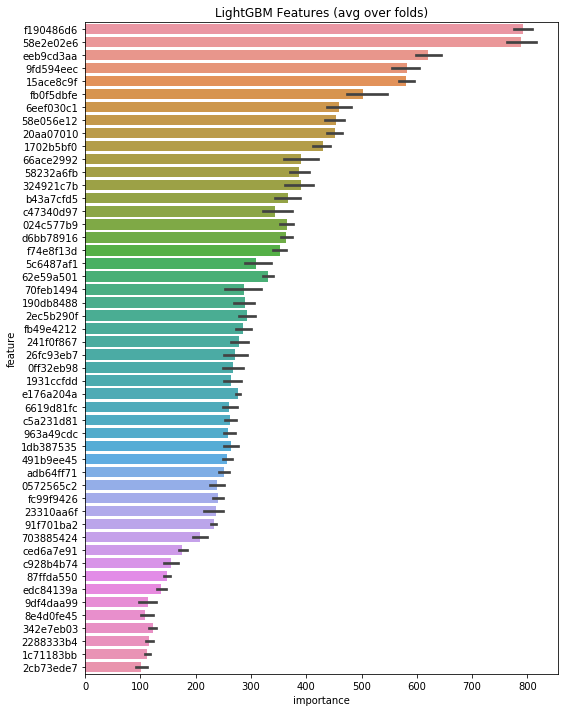

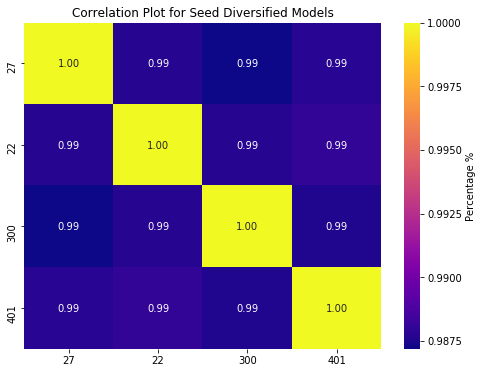

In [9]:
allmodelstart= time.time()
# Run Model with different Seeds
multi_seed_pred = dict()
all_feature_importance_df  = pd.DataFrame()

all_seeds = [27,22,300,401]
for seeds_x in all_seeds:
    modelstart= time.time()
    print("Seed: ", seeds_x,)
    # Go Go Go
    final_model_params["seed"] = seeds_x
    lgb_reg = lgb.train(
        final_model_params,
        lgtrain,
        num_boost_round = optimal_rounds + 1,
        verbose_eval=200)

    # Feature Importance
    fold_importance_df = pd.DataFrame()
    fold_importance_df["feature"] = vocab
    fold_importance_df["importance"] = lgb_reg.feature_importance()
    all_feature_importance_df = pd.concat([all_feature_importance_df, fold_importance_df], axis=0)

    multi_seed_pred[seeds_x] =  list(lgb_reg.predict(test_df))
    print("Model Runtime: %0.2f Minutes"%((time.time() - modelstart)/60))
    print("###########################################################################################")
    del lgb_reg

cols = all_feature_importance_df[["feature", "importance"]].groupby("feature").mean().sort_values(
    by="importance", ascending=False)[:50].index
best_features = all_feature_importance_df.loc[all_feature_importance_df.feature.isin(cols)]
plt.figure(figsize=(8,10))
sns.barplot(x="importance", y="feature", 
            data=best_features.sort_values(by="importance", ascending=False))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()
plt.savefig('lgbm_importances.png')
print("All Model Runtime: %0.2f Minutes"%((time.time() - allmodelstart)/60))

# To DataFrame
sub_preds = pd.DataFrame.from_dict(multi_seed_pred).replace(0,0.000001)
del multi_seed_pred; gc.collect();

# Correlation Plot
f, ax = plt.subplots(figsize=[8,6])
sns.heatmap(sub_preds.corr(),
            annot=True, fmt=".2f",cbar_kws={'label': 'Percentage %'},cmap="plasma",ax=ax)
ax.set_title("Correlation Plot for Seed Diversified Models")
plt.show()

In [10]:
# Take Mean over Seed prediction
mean_sub = np.expm1(sub_preds.mean(axis=1).rename(target_var))
mean_sub.index = testdex

# Submit
mean_sub.to_csv('mean_sub_ep{}_sc{}.csv'.format(optimal_rounds,round(best_cv_score,5))
            ,index = True, header=True)
print("Notebook Runtime: %0.2f Minutes"%((time.time() - notebookstart)/60))
mean_sub.head()

Notebook Runtime: 11.16 Minutes


ID
000137c73    2.003937e+06
00021489f    2.098791e+06
0004d7953    2.182194e+06
00056a333    6.760017e+06
00056d8eb    2.315268e+06
Name: target, dtype: float64